# Predict restaurant churn using Foursquare rating and other variables

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests
print('Libraries imported.')

Libraries imported.


Import dataset

In [2]:
licenses = pd.read_excel('SKLearn_3.xls', header = 0, delimiter = "\t")
licenses.head

<bound method NDFrame.head of     Business status  Account #                         DBA  \
0            Active      10146            A & W Restaurant   
1            Active      58190                      Aloh-O   
2            Active      56585               Amber Kitchen   
3            Active      28047  Amicis East Coast Pizzeria   
4            Active      56835    Antiguas Cafe Restaurant   
..              ...        ...                         ...   
201          Active      47341             Whipper Snapper   
202          Active      57558                      Woking   
203          Active      33766                     Yet Wah   
204          Active      12580   Yu Shang Mandarin Cuisine   
205          Active      57722                  Yuzu Ramen   

              Bus Address       Ownership type       Geo  Start date  \
0        3741 REDWOOD HWY          Partnership        TL   5/16/1978   
1       276 NORTHGATE DR           Corporation        TL   6/18/2018   
2        

Perform exploratory data analysis

In [3]:
licenses['Business status'].value_counts()

Active      187
Closeout     19
Name: Business status, dtype: int64

In [4]:
licenses['Ownership type'].value_counts()

Corporation            95
Sole Proprietorship    60
Ltd Liability Co       42
Partnership             9
Name: Ownership type, dtype: int64

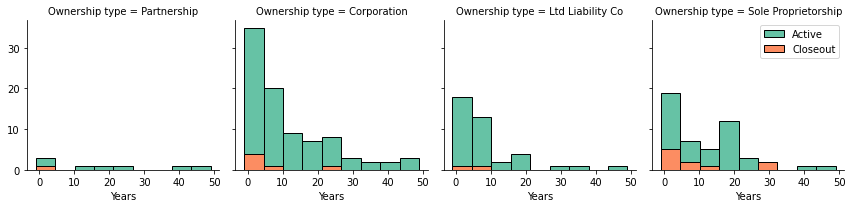

In [5]:
bins = np.linspace(licenses.Years.min(), licenses.Years.max(), 10)
g = sns.FacetGrid(licenses, col="Ownership type", hue = "Business status", palette = "Set2", col_wrap = 4)
g.map(plt.hist, 'Years', bins = bins, ec = "k")
g.axes[-1].legend()
plt.show()

In [6]:
licenses['Geo'].value_counts()

Downtown            114
TL                   42
Canal                28
Northgate Ind Pk     11
Br Harte              9
SP Ridge              1
Linc/SV               1
Name: Geo, dtype: int64

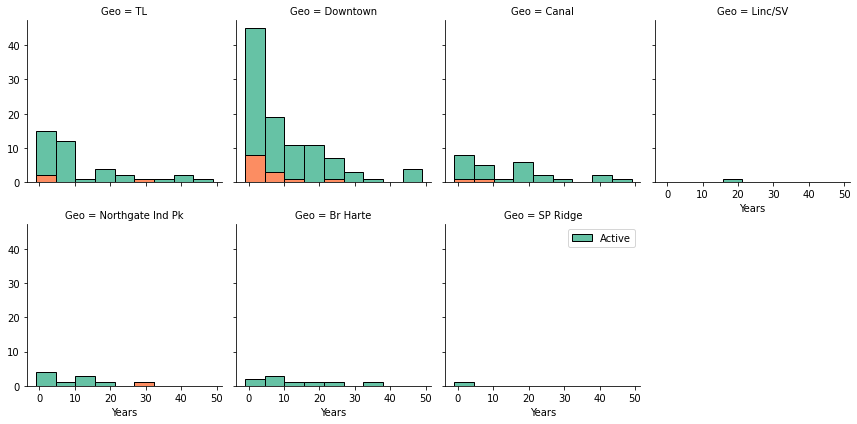

In [7]:
bins = np.linspace(licenses.Years.min(), licenses.Years.max(), 10)
g = sns.FacetGrid(licenses, col = "Geo", hue = "Business status", palette = "Set2", col_wrap=4)
g.map(plt.hist, 'Years', bins = bins, ec = "k")
g.axes[-1].legend()
plt.show()

In [8]:
# Note that many neighborhoods have few records compared to downtown

licenses['Downtown'] = licenses['Geo'].apply(lambda x: "Y" if (x == "Downtown") else "N") # consolidate neighborhoods into Downtown and not Downtown

In [9]:
licenses.head

<bound method NDFrame.head of     Business status  Account #                         DBA  \
0            Active      10146            A & W Restaurant   
1            Active      58190                      Aloh-O   
2            Active      56585               Amber Kitchen   
3            Active      28047  Amicis East Coast Pizzeria   
4            Active      56835    Antiguas Cafe Restaurant   
..              ...        ...                         ...   
201          Active      47341             Whipper Snapper   
202          Active      57558                      Woking   
203          Active      33766                     Yet Wah   
204          Active      12580   Yu Shang Mandarin Cuisine   
205          Active      57722                  Yuzu Ramen   

              Bus Address       Ownership type       Geo  Start date  \
0        3741 REDWOOD HWY          Partnership        TL   5/16/1978   
1       276 NORTHGATE DR           Corporation        TL   6/18/2018   
2        

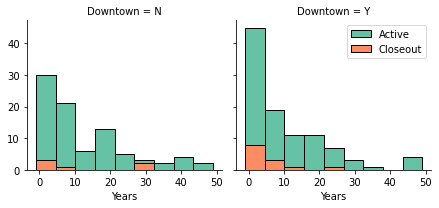

In [10]:
bins = np.linspace(licenses.Years.min(), licenses.Years.max(), 10)
g = sns.FacetGrid(licenses, col = "Downtown", hue = "Business status", palette = "Set2", col_wrap = 4)
g.map(plt.hist, 'Years', bins = bins, ec = "k")
g.axes[-1].legend()
plt.show()

Load Foursquare credentials

In [11]:
Foursquare_json = json.loads(open('Foursquare.json').read())

In [12]:
CLIENT_ID = Foursquare_json['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = Foursquare_json['CLIENT_SECRET'] # your Foursquare Secret
VERSION = Foursquare_json['VERSION'] # Foursquare API version
LIMIT = 500
radius = 700

Get Foursquare IDs and ratings for every record

In [13]:
def getID(arg1, arg2):
    address = arg1 + ', San Rafael, CA'
    geolocator = Nominatim(user_agent = "foursquare_agent")
    
    try:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        search_query = arg2
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        result = requests.get(url).json()  
    # assign relevant part of JSON to venues
        venues = result['response']['venues']
        venue_ID = venues[0]['id']
        venue_name = venues[0]['name']

    except:        
        venue_ID = '' #failed to retrieve
        venue_name = '' #failed to retrieve
        
    finally:
        return venue_name, venue_ID

In [14]:
def getRating(arg1):
    
    if arg1 == '':
        return '' #assume failure to locate implies not popular enough to garner any rating
    
    else:
        try:
            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(arg1, CLIENT_ID, CLIENT_SECRET, VERSION)
            result = requests.get(url).json()
            venue_rating = result['response']['venue']['rating']
                
        except:
            venue_rating = '' #failed to retrieve
            
        finally:
            return venue_rating

In [15]:
getID('5800 Northgate Dr', 'Berry Twist')

('Berry Twist Yogurt', '4c438362dcd61b8d7f1c7a56')

In [16]:
getRating('4c438362dcd61b8d7f1c7a56')

7.1

In [17]:
Foursquare_names = []
Foursquare_IDs = []

for i in range(0,len(licenses)):
    results = getID(licenses.iloc[i][3], licenses.iloc[i][2])
    Foursquare_names.append(results[0])
    Foursquare_IDs.append(results[1])

In [18]:
list(zip(Foursquare_names, Foursquare_IDs))

[('A&W Restaurant', '49eb96d5f964a520f8661fe3'),
 ('Aloh-o Poke, Bento, And Sushi', '5b2ab40e1acf11002c1c2578'),
 ('Amber Kitchen', '5781bce2498e65d291c854d6'),
 ("Amici's East Coast Pizzeria", '4b455805f964a520f20a26e3'),
 ('Antiguas Cafe', '5d66e844ca17630008f17913'),
 ("Applebee's Grill + Bar", '4b4a470ff964a520fa8126e3'),
 ('Arigatou', '4b7239c1f964a520aa742de3'),
 ('Aroma Café', '4aa41a9cf964a5204f4520e3'),
 ('', ''),
 ('Bagel Street Cafe', '4b295375f964a520e99c24e3'),
 ('Bagel Street Cafe', '50ca1e01498edd8aad881392'),
 ('Bangkok Thai Express', '4b1ad39ef964a520aaf223e3'),
 ('Banh Mi & Coffee', '5c463a2cbd4009002c820423'),
 ('', ''),
 ('Bay Thai Cuisine', '4a9da1fdf964a520b83820e3'),
 ('Berry Twist Yogurt', '4c438362dcd61b8d7f1c7a56'),
 ('Best Burger', '4b5a2cb9f964a52015b228e3'),
 ('Better Bar', '5b3e913a9ba3e5002cc0260e'),
 ("BJ's Restaurant & Brewhouse", '4af9dc8df964a520d71422e3'),
 ('Black Bear Diner', '59a670bee96d0c47fb62590d'),
 ("Bogie's Too", '5ca0f784829b0c002c996afc')

In [19]:
licenses['Foursquare ID'] = Foursquare_IDs
licenses.head

<bound method NDFrame.head of     Business status  Account #                         DBA  \
0            Active      10146            A & W Restaurant   
1            Active      58190                      Aloh-O   
2            Active      56585               Amber Kitchen   
3            Active      28047  Amicis East Coast Pizzeria   
4            Active      56835    Antiguas Cafe Restaurant   
..              ...        ...                         ...   
201          Active      47341             Whipper Snapper   
202          Active      57558                      Woking   
203          Active      33766                     Yet Wah   
204          Active      12580   Yu Shang Mandarin Cuisine   
205          Active      57722                  Yuzu Ramen   

              Bus Address       Ownership type       Geo  Start date  \
0        3741 REDWOOD HWY          Partnership        TL   5/16/1978   
1       276 NORTHGATE DR           Corporation        TL   6/18/2018   
2        

In [20]:
licenses.drop(licenses[licenses['Foursquare ID'] == ''].index, inplace = True) 
licenses.reset_index(drop = True, inplace = True)

In [21]:
licenses.head

<bound method NDFrame.head of     Business status  Account #                         DBA  \
0            Active      10146            A & W Restaurant   
1            Active      58190                      Aloh-O   
2            Active      56585               Amber Kitchen   
3            Active      28047  Amicis East Coast Pizzeria   
4            Active      56835    Antiguas Cafe Restaurant   
..              ...        ...                         ...   
165          Active      47341             Whipper Snapper   
166          Active      57558                      Woking   
167          Active      33766                     Yet Wah   
168          Active      12580   Yu Shang Mandarin Cuisine   
169          Active      57722                  Yuzu Ramen   

              Bus Address       Ownership type       Geo  Start date  \
0        3741 REDWOOD HWY          Partnership        TL   5/16/1978   
1       276 NORTHGATE DR           Corporation        TL   6/18/2018   
2        

In [22]:
getRating(licenses.iloc[0][12])

6.8

In [23]:
scores = []

for i in range(0,len(licenses)):
    result = getRating(licenses.iloc[i][12])
    scores.append(result)

In [24]:
list(zip(licenses['DBA'], scores))

[('A & W Restaurant', 6.8),
 ('Aloh-O', ''),
 ('Amber Kitchen', ''),
 ('Amicis East Coast Pizzeria', 7.7),
 ('Antiguas Cafe Restaurant', ''),
 ('Applebees Grill + Bar', 6.6),
 ('Arigatou', ''),
 ('Aroma Cafe', 6.7),
 ('Bagel Street Cafe', 7.4),
 ('Bagel Street Cafe', 6.2),
 ('Bangkok Thai Express, Inc.', 6.1),
 ('Banh Mi & Coffee', ''),
 ('Bay Thai Cuisine', 7.5),
 ('Berry Twist', 7.1),
 ('Best Burger', 7.2),
 ('Better Bar', ''),
 ("BJ's Restaurant & Brewhouse", 7.0),
 ('Black Bear Diner', 7.6),
 ("Bogie's Too", ''),
 ('Bombay Grill', ''),
 ('Cafe Del Soul', 8.7),
 ('Caffe Villa At Villa Inn', ''),
 ('Calgang Thai', 6.8),
 ('Casa Manana Restaurant', 8.6),
 ("Celia's Mexican Restaurant", 7.3),
 ('Chipotle Mexican Grill ', 6.9),
 ('Chipotle Mexican Grill ', 8.0),
 ('Chonmage', ''),
 ('Cold Stone Creamery', 8.0),
 ('Cornucopia Cafe & Catering', ''),
 ('Crepevine', 6.5),
 ('Depot Garden Cafe', 7.3),
 ("Domino's Pizza", 6.5),
 ('Double Rainbow Cafe', 8.0),
 ("Eduardo's Restaurant", 7.3),
 (

In [25]:
licenses['Rating'] = scores
licenses.head

<bound method NDFrame.head of     Business status  Account #                         DBA  \
0            Active      10146            A & W Restaurant   
1            Active      58190                      Aloh-O   
2            Active      56585               Amber Kitchen   
3            Active      28047  Amicis East Coast Pizzeria   
4            Active      56835    Antiguas Cafe Restaurant   
..              ...        ...                         ...   
165          Active      47341             Whipper Snapper   
166          Active      57558                      Woking   
167          Active      33766                     Yet Wah   
168          Active      12580   Yu Shang Mandarin Cuisine   
169          Active      57722                  Yuzu Ramen   

              Bus Address       Ownership type       Geo  Start date  \
0        3741 REDWOOD HWY          Partnership        TL   5/16/1978   
1       276 NORTHGATE DR           Corporation        TL   6/18/2018   
2        

In [26]:
licenses.drop(licenses[licenses['Rating'] == ''].index, inplace = True) 
licenses.reset_index(drop = True, inplace = True)

In [27]:
licenses.head

<bound method NDFrame.head of     Business status  Account #                         DBA        Bus Address  \
0            Active      10146            A & W Restaurant   3741 REDWOOD HWY   
1            Active      28047  Amicis East Coast Pizzeria        1242 4TH ST   
2            Active      33898       Applebees Grill + Bar  5800 NORTHGATE DR   
3            Active      34725                  Aroma Cafe        1122 4TH ST   
4            Active      35476           Bagel Street Cafe  208 NORTHGATE DR    
..              ...        ...                         ...                ...   
108          Active      58176         West Brooklyn Pizza    900 ANDERSEN DR   
109          Active      47341             Whipper Snapper        1613 4TH ST   
110          Active      33766                     Yet Wah   1236-1238 4TH ST   
111          Active      12580   Yu Shang Mandarin Cuisine    180 BELLAM BLVD   
112          Active      57722                  Yuzu Ramen         908 4TH ST  

In [28]:
label_encoder = preprocessing.LabelEncoder()

In [29]:
licenses['Business status'] = label_encoder.fit_transform(licenses['Business status'])
licenses['Ownership type'] = label_encoder.fit_transform(licenses['Ownership type'])
licenses['Tags'] = label_encoder.fit_transform(licenses['Tags'])
licenses['Downtown'] = label_encoder.fit_transform(licenses['Downtown'])

In [30]:
y = licenses['Business status'].values.astype(np.int)

In [31]:
licenses.drop(['Business status', 'Account #', 'DBA', 'Bus Address', 'Geo', 'Start date', 'Close date', 'Expiration date', 'Foursquare ID'], axis = 1, inplace = True)
licenses.head

<bound method NDFrame.head of      Ownership type  Years  Tags  Downtown Rating
0                 2     41     0         0    6.8
1                 0     24     0         1    7.7
2                 1     18     0         0    6.6
3                 0     17     0         1    6.7
4                 3     18     0         0    7.4
..              ...    ...   ...       ...    ...
108               3      2     0         0    6.1
109               1     11     0         1    7.4
110               1     18     0         1    6.6
111               3     40     0         0    7.1
112               0      2     0         1    7.9

[113 rows x 5 columns]>

In [32]:
X = licenses.values.astype(np.float)

In [33]:
print(type(X))
print(X.shape)
print(X[0])
print(y.shape)
print(y[0])

<class 'numpy.ndarray'>
(113, 5)
[ 2.  41.   0.   0.   6.8]
(113,)
0


In [34]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [35]:
print('There are {} instances of closed businesses and {} instances of surviving businesses.'.format(y.sum(), y.shape[0] - y.sum()))
print('Percentage of businesses that closed: {:.2f}'.format(float(100 * y.sum()) / y.shape[0]))

There are 6 instances of closed businesses and 107 instances of surviving businesses.
Percentage of businesses that closed: 5.31


Optimize k (from Coursera's Machine Learning With Python)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [37]:
scaler = StandardScaler()

In [38]:
Ks = 25
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat == y_test)/np.sqrt(yhat.shape[0])

optimal_k = mean_acc.argmax()+1
print("Optimal k =", optimal_k)

Optimal k = 1


Apply various classifiers

In [39]:
def stratified_cv(X, y, clf_class, n_splits = 5, shuffle = True, random_state = 4, **kwargs):
    stratified_k_fold = model_selection.StratifiedKFold(n_splits = n_splits, shuffle = shuffle, random_state = random_state)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold.split(X,y):
        X_train, X_test = X[ii], X[jj]
        
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train, y_train)
        y_pred[jj] = clf.predict(X_test)
        
    return y_pred

In [40]:
y_pred_pac = stratified_cv(X, y, linear_model.PassiveAggressiveClassifier)
y_pred_rc = stratified_cv(X, y, linear_model.RidgeClassifier)
y_pred_LR = stratified_cv(X, y, linear_model.LogisticRegression) 
y_pred_gbc = stratified_cv(X, y, ensemble.GradientBoostingClassifier)
y_pred_abc = stratified_cv(X, y, ensemble.AdaBoostClassifier)
y_pred_rfc = stratified_cv(X, y, ensemble.RandomForestClassifier)
y_pred_dtc = stratified_cv(X, y, tree.DecisionTreeClassifier)
y_pred_SVM = stratified_cv(X, y, svm.SVC)
y_pred_KNN = stratified_cv(X, y, neighbors.KNeighborsClassifier, n_neighbors = optimal_k)

In [41]:
print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(y, y_pred_pac)))
print('Ridge Classifier:              {:.2f}'.format(metrics.accuracy_score(y, y_pred_rc)))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, y_pred_LR)))
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, y_pred_gbc)))
print('AdaBoost Classifier:           {:.2f}'.format(metrics.accuracy_score(y, y_pred_abc)))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, y_pred_rfc)))
print('Decision Tree Classifier:      {:.2f}'.format(metrics.accuracy_score(y, y_pred_dtc)))
print('Support Vector Machine (SVM):  {:.2f}'.format(metrics.accuracy_score(y, y_pred_SVM)))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, y_pred_KNN)))
print('Naive Classifier:              {:.2f}'.format(metrics.accuracy_score(y, [0 for ii in y.tolist()])))

Passive Aggressive Classifier: 0.91
Ridge Classifier:              0.95
Logistic Regression:           0.95
Gradient Boosting Classifier:  0.94
AdaBoost Classifier:           0.94
Random Forest Classifier:      0.95
Decision Tree Classifier:      0.86
Support Vector Machine (SVM):  0.95
K Nearest Neighbor Classifier: 0.94
Naive Classifier:              0.95


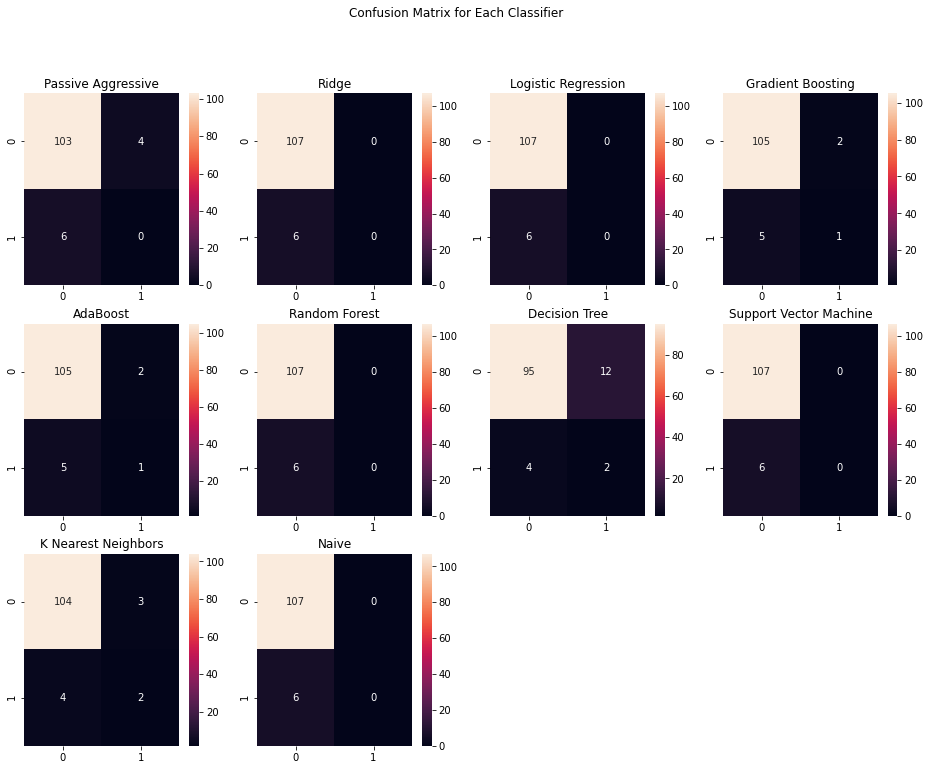

In [42]:
pass_agg_conf_matrix = metrics.confusion_matrix(y, y_pred_pac)
ridge_clf_conf_matrix = metrics.confusion_matrix(y, y_pred_rc)
logistic_reg_conf_matrix = metrics.confusion_matrix(y, y_pred_LR)
gradboost_conf_matrix = metrics.confusion_matrix(y, y_pred_gbc)
adaboost_conf_matrix = metrics.confusion_matrix(y, y_pred_abc)
random_forest_conf_matrix = metrics.confusion_matrix(y, y_pred_rfc)
decision_conf_matrix = metrics.confusion_matrix(y, y_pred_dtc)
svm_svc_conf_matrix = metrics.confusion_matrix(y, y_pred_SVM)
knn_conf_matrix = metrics.confusion_matrix(y, y_pred_KNN)
naive_conf_matrix = metrics.confusion_matrix(y, [0 for ii in y.tolist()]);

conf_matrix = {
                1: {
                    'matrix': pass_agg_conf_matrix,
                    'title': 'Passive Aggressive',
                   },
                2: {
                    'matrix': ridge_clf_conf_matrix,
                    'title': 'Ridge',
                   },
                3: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',   
                   },
                4: {
                    'matrix': gradboost_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                5: {
                    'matrix': adaboost_conf_matrix,
                    'title': 'AdaBoost'
                   },
                6: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                7: {
                    'matrix': decision_conf_matrix,
                    'title': 'Decision Tree',
                   },
                8:  {    
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                },
                9: {
                    'matrix': knn_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
               10: {
                    'matrix': naive_conf_matrix,
                    'title': 'Naive',
                   },
}

fix, ax = plt.subplots(figsize = (16, 12))
plt.suptitle('Confusion Matrix for Each Classifier')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 4, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot = True,  fmt = '');

In [43]:
print('Passive Aggressive Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_pac)))
print('Ridge Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_rc))) 
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, y_pred_LR)))
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_gbc)))
print('AdaBoost Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_abc)))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_rfc)))
print('Decision Tree Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_dtc))) 
print('Support Vector Machine (SVM):\n {}\n'.format(metrics.classification_report(y, y_pred_SVM)))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, y_pred_KNN)))
print('Naive Classifier:\n {}\n'.format(metrics.classification_report(y, [0 for ii in y.tolist()]))); 

Passive Aggressive Classifier:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       107
           1       0.00      0.00      0.00         6

    accuracy                           0.91       113
   macro avg       0.47      0.48      0.48       113
weighted avg       0.89      0.91      0.90       113


Ridge Classifier:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       0.00      0.00      0.00         6

    accuracy                           0.95       113
   macro avg       0.47      0.50      0.49       113
weighted avg       0.90      0.95      0.92       113


Logistic Regression:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       0.00      0.00      0.00         6

    accuracy                           0.95       113
   macro avg       0.47      0.50      0.49       113

c:\users\andrew\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Examine Feature Importance among Ensemble classifiers

In [44]:
def getFeatureImportance(clf_class, clf_name):
    feature_importance = clf_class.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize = (16, 12))
    plt.barh(pos, feature_importance[sorted_idx], align = 'center', color = '#65c2a5')  
    plt.yticks(pos, np.asanyarray(licenses.columns.tolist())[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(clf_name + 'Variable Importance')
    plt.show()

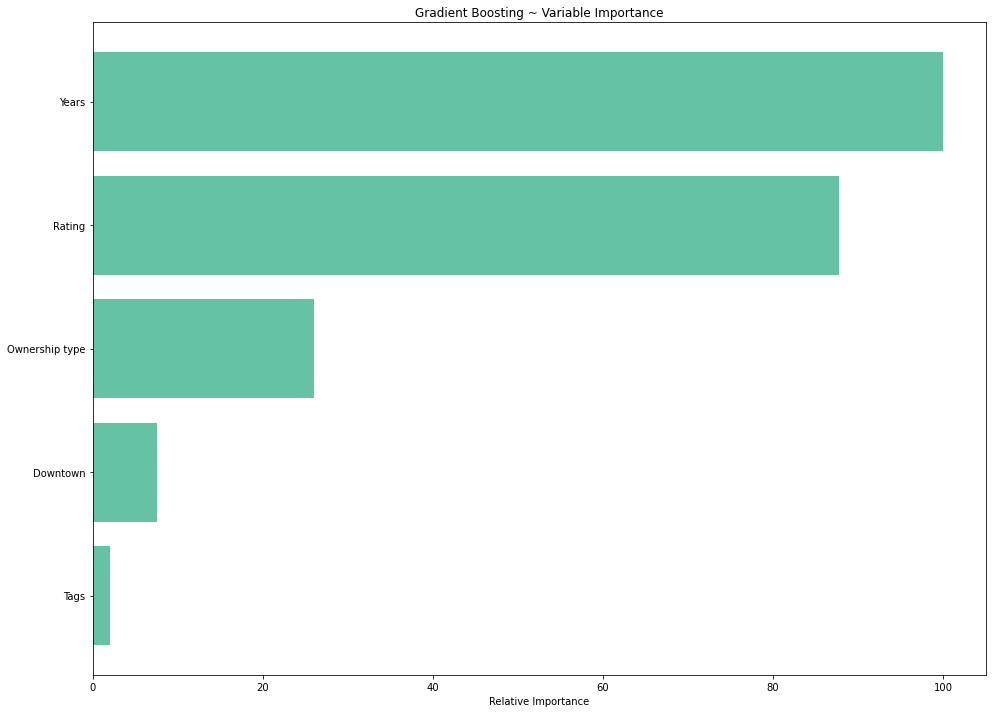

In [45]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)
getFeatureImportance(gbc, 'Gradient Boosting ~ ')

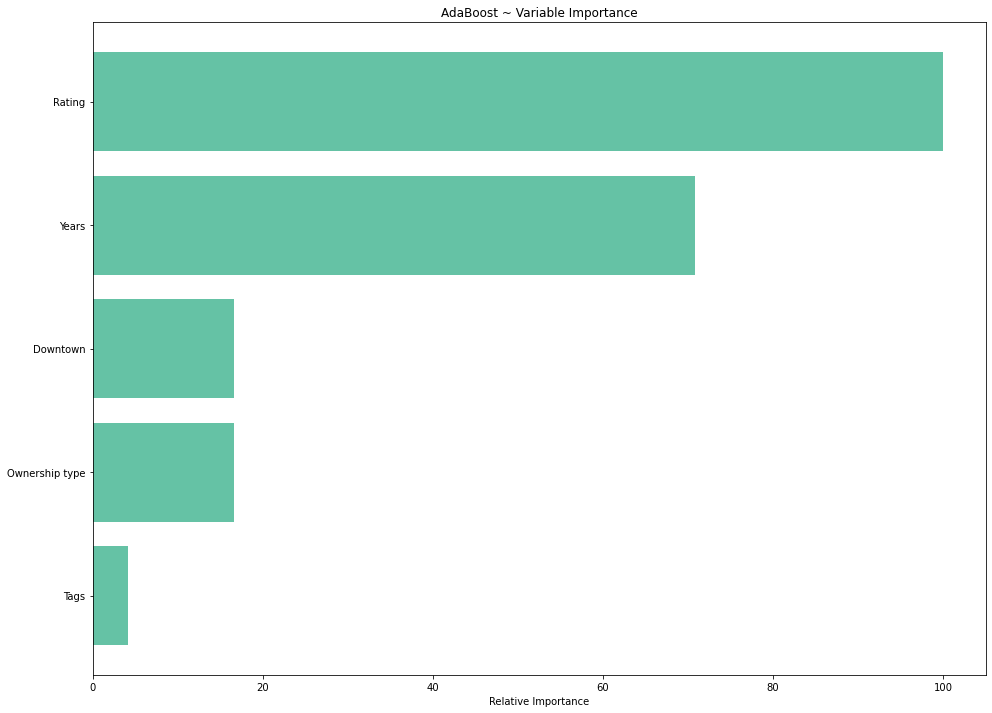

In [46]:
abc = ensemble.AdaBoostClassifier()
abc.fit(X,y)
getFeatureImportance(abc, 'AdaBoost ~ ')

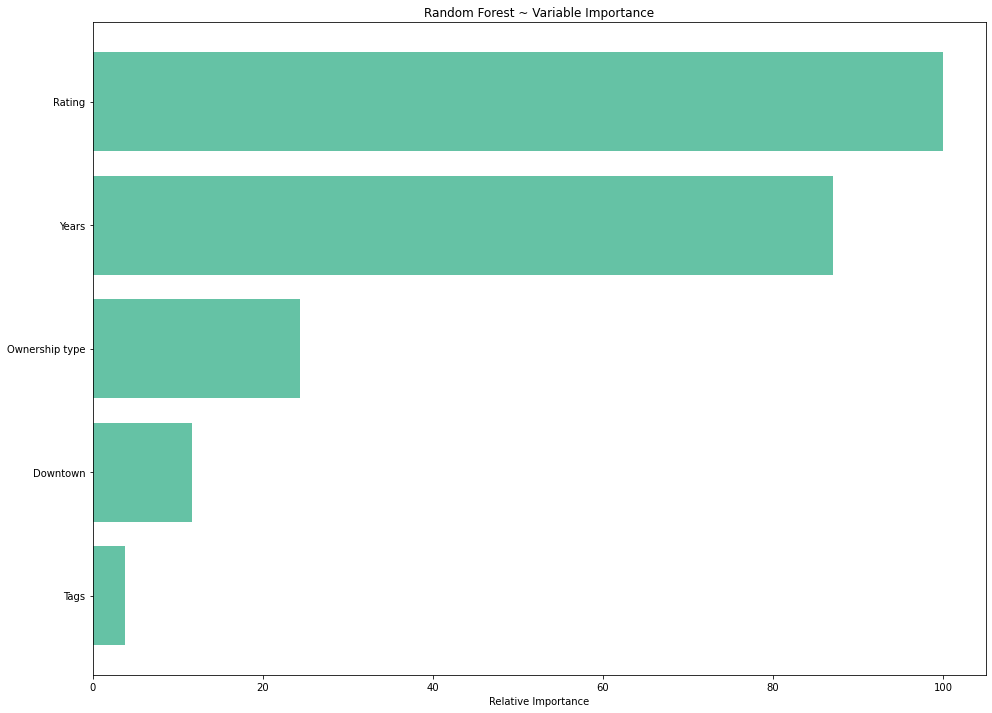

In [47]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X, y)
getFeatureImportance(rfc, 'Random Forest ~ ')

Retrain classifiers using squared variable for Years

In [48]:
licenses['Years_2'] = licenses['Years']**2

In [49]:
licenses.drop(['Years'], axis = 1, inplace = True)

In [50]:
print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Ridge Classifier:              {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.RidgeClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('AdaBoost Classifier:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.AdaBoostClassifier))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('Decision Tree Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, tree.DecisionTreeClassifier))))
print('Support Vector Machine (SVM):  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier, n_neighbors = optimal_k))))
print('Naive Classifier:              {:.2f}'.format(metrics.accuracy_score(y, [0 for ii in y.tolist()])))

Passive Aggressive Classifier: 0.88
Ridge Classifier:              0.95
Logistic Regression:           0.95
Gradient Boosting Classifier:  0.94
AdaBoost Classifier:           0.94
Random Forest Classifier:      0.95
Decision Tree Classifier:      0.87
Support Vector Machine (SVM):  0.95
K Nearest Neighbor Classifier: 0.94
Naive Classifier:              0.95


Drop Years feature altogether

In [51]:
licenses.drop(['Years_2'], axis = 1, inplace = True)

In [52]:
print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Ridge Classifier:              {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.RidgeClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression)))) 
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('AdaBoost Classifier:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.AdaBoostClassifier))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('Decision Tree Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, tree.DecisionTreeClassifier))))
print('Support Vector Machine (SVM):  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier, n_neighbors = optimal_k))))
print('Naive Classifier:              {:.2f}'.format(metrics.accuracy_score(y, [0 for ii in y.tolist()])))

Passive Aggressive Classifier: 0.88
Ridge Classifier:              0.95
Logistic Regression:           0.95
Gradient Boosting Classifier:  0.94
AdaBoost Classifier:           0.94
Random Forest Classifier:      0.95
Decision Tree Classifier:      0.86
Support Vector Machine (SVM):  0.95
K Nearest Neighbor Classifier: 0.94
Naive Classifier:              0.95
